<div style="font-family: Arial; text-align: center;">

## Monte Carlo Simulation
#### Kannan Singaravelu, CQF

##  <strong> 1 Monte Carlo Approach

Monte Carlo methods are any process that consumes random numbers. These are part of computational
algorithms which are based on random sampling to obtain numerical results. Monte Carlo
methods are proved to be a very valuable and flexible computational tool in finance and is one of
the most widely used methods for optimization and numerical integration problems.


These methods are widely used in high dimensional problems; pricing exotics and complex derivatives
where closed form solutions are not directly available. Monte Carlo methods are not just
adapted in pricing complex derivatives, It is also extensively used in estimating the portfolio risk
such as Value-at-Risk and Expected Shortfall and used in the calculation of worst-case scenarios in
stress testing. The downside to that is, it is very computational intensive and demanding.

###  <strong> 1.1 Monte Carlo Simulation

A method of estimating the value of an unknown quantity using the principles of inferential statistics.


We take the **population** and then we **sample** it by drawing a proper subset. And then we make
an inference about the population based upon some set of statistics we do on the sample.


And, the key fact that makes them work, that if we choose the sample at **random**, the sample will
tend to exhibit the same properties as the population from which it is drawn.

###  <strong> 1.2 Option Pricing Techniques

As with other option pricing techniques Monte Carlo methods are used to price options using what
is essentially a three step process.

**Step 1**: Simulate potential price paths of the underlying asset.

**Step 2**: Calculate the option payoff for each of these price paths.

**Step 3**: Average the payoff and discount back to today to determine the option price.

##  <strong> 2 Simulating Asset Prices

Next, we will simulate the asset price at maturity $S_T$. Following Black-Scholes-Merton where the underlying follows under risk neutrality, a geometric Brownian motion with a stochastic differential equation (SDE) is given as

$$
dS_t = rS_t dt + \sigma S_t dW_t
$$

where $S_t$ is the price of the underlying at time $t$, $\sigma$ is constant volatility, $r$ is the constant risk-free interest rate, and $W_t$ is the Brownian motion.

Applying Euler discretization of the SDE, we get

$$
S_{t+\delta t} = S_t (1 + r \delta t + \sigma \sqrt{\delta t} w_t)
$$

It is often more convenient to express in time stepping form

$$
S_{t+\delta t} = S_t \exp\left((r - \frac{1}{2} \sigma^2) \delta t + \sigma \sqrt{\delta t} w_t\right)
$$

The variable $w_t$ is a standard normally distributed random variable, $0 < \delta t < T$, the time interval. It also holds that $0 < t \leq T$ with $T$ the final time horizon.


###  <strong> 2.1 Generate Price Paths

Simulating price paths plays an important role in the valuation of derivatives and it is always
prudent to create a separate path function.

**Import Required Libraries**

In [2]:
# IMporting libraries
import warnings 
warnings.filterwarnings('ignore')

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opstrat as ep

# Set max row to 300
pd.set_option('display.max_rows', 300)

In [3]:
class MonteCarloOptionPricing:
    ''' Monte Carlo Option Pricing Engine'''
    def __init__(self, S0:float, strike:float, rate:float, sigma:float, dte:int,nsim:int, timesteps:int=252) -> float:
        self.S0 = S0 # Initial stock price
        self.K = strike # Strike price
        self.r = rate # Risk-free interest rate
        self.sigma = sigma # Volatility
        self.T = dte # Time to expiration
        self.N = nsim # Number of simulations
        self.ts = timesteps # Time steps

    @property
    def psuedorandomnumber(self):
        ''' generate psuedo random numbers'''
        return np.random.standard_normal(self.N)

    @property
    def simulatepath(self):
        ''' simulate price path'''
        np.random.seed(2024)
        
        # define dt
        dt = self.T/self.ts
        
        # simulate path
        S = np.zeros((self.ts, self.N))
        S[0] = self.S0
        
        for i in range(0, self.ts-1):
            w = self.psuedorandomnumber
            S[i+1] = S[i] * (1+ self.r*dt + self.sigma * np.sqrt(dt)*w)
        return S
    @property
    def vanillaoption(self):
            ''' calculate vanilla option payoff'''
            S = self.simulatepath
            # calculate the discounted value of the expeced payoff
            vanilla_call = np.exp(-self.r*self.T) * np.mean(np.maximum(0, S[-1]-self.K))
            vanilla_put = np.exp(-self.r*self.T) * np.mean(np.maximum(0, self.K-S[-1]))
            return [vanilla_call, vanilla_put]

    @property
    def asianoption(self):
        ''' calculate asian option payoff'''
        S = self.simulatepath
        # average the price across days
        A = S.mean(axis=0)
        # calculate the discounted value of the expeced payoff
        asian_call = np.exp(-self.r*self.T) * np.mean(np.maximum(0, A-self.K))
        asian_put = np.exp(-self.r*self.T) * np.mean(np.maximum(0, self.K-A))
        return [asian_call, asian_put]
        
    def upandoutcall(self, barrier:int=150, rebate:int=0) -> float:
        ''' calculate up-and-out barrier option payoff'''
        S = self.simulatepath
        # Barrier shift - continuity correction for discrete monitoring
        barriershift = barrier*np.exp(0.5826 * self.sigma * np.sqrt(self.T/self.ts))
        value=0
        for i in range(self.N):
            if S[:,i].max() < barriershift:
                value += np.maximum(0, S[-1,i]-self.K)
            else:
                value += rebate
        return [np.exp(-self.r*self.T) * value/self.N, barriershift]      

In [4]:
# instantiate
mc = MonteCarloOptionPricing(100,100,0.05,0.2,1,100000)
# Verify the generated price paths
pd.DataFrame(mc.simulatepath).head(2)

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.00000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.00000,100.000000,100.000000
1,102.121383,100.948812,99.765928,99.82971,101.173958,101.481719,96.718999,98.350127,100.599372,100.148414,...,100.34369,101.838621,99.128963,100.129858,97.246274,99.60355,101.377545,99.49875,98.363364,99.097818


In [5]:
pd.DataFrame(mc.simulatepath).tail(2)

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
250,141.437673,119.854615,90.473423,147.121107,124.461143,83.101166,111.542425,124.106212,116.674454,163.886254,...,105.746454,107.471261,115.694412,123.081588,113.559476,90.912640,70.243959,77.676287,112.050906,103.906380
251,142.982456,120.072472,90.316633,148.781911,122.771249,84.048953,113.849639,124.499340,117.936273,167.296821,...,106.739564,106.694851,115.834640,123.167677,112.881114,91.791613,70.620528,76.259556,112.470420,103.800921


**Histogram of Psuedo Random Numbers**

In [6]:
mc.simulatepath[-1]

array([142.98245637, 120.07247181,  90.31663324, ...,  76.25955603,
       112.47041986, 103.80092128])

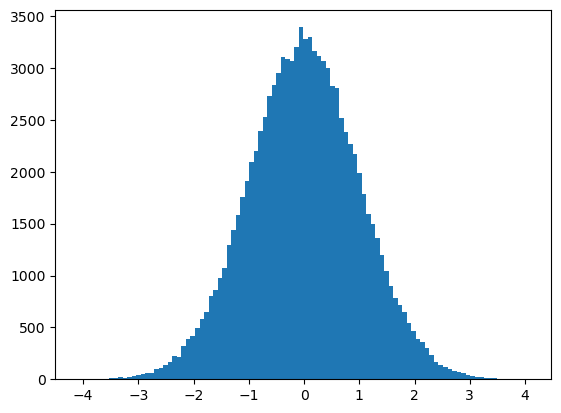

In [7]:
# Plot the histogram
plt.hist(mc.psuedorandomnumber, bins=100);

**Histogram of Simulated Paths**

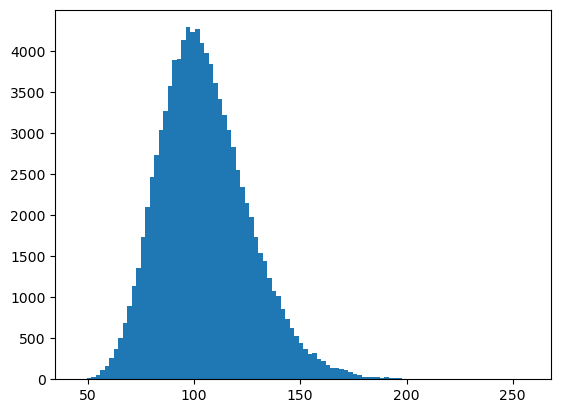

In [8]:
#Plot the histogram of the simulated price path at maturity
plt.hist(mc.simulatepath[-1], bins=100);

**Visualization of Simulated Paths**

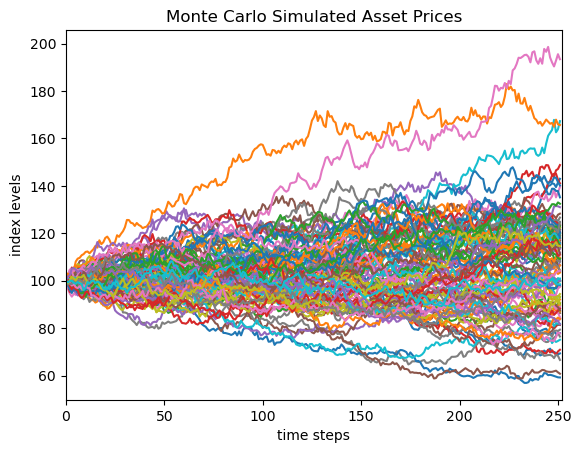

In [9]:
# Plot initial 100 simulated path using matplotlib
plt.plot(mc.simulatepath[:,:100])
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('index levels')
plt.title('Monte Carlo Simulated Asset Prices');

##  <strong> 3 Risk-Neutral Valuation

A call option gives the holder of the option the right to buy the asset at a pre-defined price. A call buyer makes money if the price of the asset at maturity, denoted by $S_T$, is above the strike price $K$, otherwise it's worth nothing.

<center>\( C_T = \max(0, S_T - K) \)</center>

The price of an option using a Monte Carlo simulation is the expected value of its future payoff. So at any date before maturity, denoted by $t$, the option's value is the present value of the expectation of its payoff at maturity $T$.

<center>\( C = PV(\mathbb{E}[\max(0, S_T - K)]) \)</center>

Under the risk-neutral framework, we assume the asset is going to earn, on average, the risk-free interest rate. Hence, the option value at time $t$ would simply be the discounted value of the expected payoff.

<center>\( C = e^{r(T-t)} \mathbb{E}[\max(0, S_T - K)] \)</center>

**European Option**  
To price an option, we generate many possible price paths that the asset might take at maturity and then calculate option payoffs for each of those generated prices, average them to get the expected payoff and then discount it at risk free to arrive at the final value.

Given that Monte Carlo algorithms are computationally heavy, it is necessary to implement efficiently. We'll use vectorization with NumPy for effective algorithm as NumPy syntax are more compact and are faster.


In [10]:
mc.vanillaoption[0], mc.vanillaoption[1]

(10.435249128636812, 5.530523707013182)

In [11]:
# Get option vaues
print(f"European Call Option Value is {mc.vanillaoption[0]:0.4f}")
print(f"European Put Option Value is {mc.vanillaoption[1]:0.4f}")

European Call Option Value is 10.4352
European Put Option Value is 5.5305


**Plot Payoff**

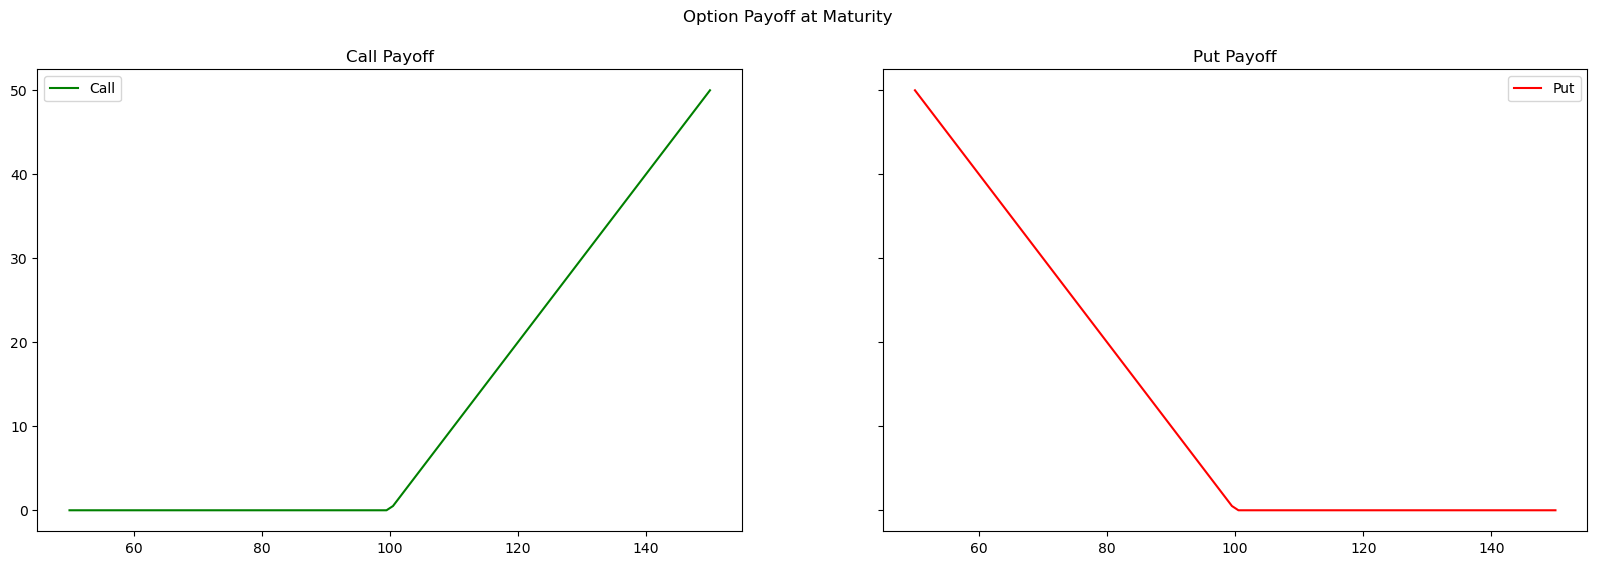

In [12]:
# range of spot prices
sT= np.linspace(50,150,100)

# visualize call and put price for range of spot prices
figure, axes = plt.subplots(1,2, figsize=(20,6), sharey=True)
title, payoff, color, label = ['Call Payoff', 'Put Payoff'], [np.maximum(sT-mc.K, 0), np.maximum(mc.K-sT, 0)], ['green', 'red'], ['Call', 'Put']

# plot payoff
for i in range(2):
    axes[i].plot(sT, payoff[i], color=color[i], label=label[i])
    axes[i].set_title(title[i])
    axes[i].legend()
    figure.suptitle('Option Payoff at Maturity');

**Asian Call Option**

An Asian option is an option where the payoff depends on the average price of the underlying asset over a certain period of time. Averaging can be either Arithmetic or Geometric. There are two types of Asian options: fixed strike, where the averaging price is used in place of the underlying price; and fixed price, where the averaging price is used in place of the strike.

We’ll now price a fixed strike arithmetic average option using Monte Carlo simulation.

The payoff of the options is given by

$$
C_T = \max\left(0, \frac{1}{T} \sum_{i=1}^{T} S_i - K\right)
$$

$$
C_T = \max(0, S_{\text{Avg}} - K)
$$

where $S_{\text{Avg}}$ is the average price of the underlying asset over the life of the option. To price an option using a Monte Carlo simulation, we use a risk-neutral valuation, where the fair value for a derivative is the expected value of its future payoff. So at any date before maturity, denoted by $t$, the option’s value is the present value of the expectation of its payoff at maturity $T$.

$$
C = PV(\mathbb{E}[\max(0, S_{\text{Avg}} - K)])
$$

Under the risk-neutral framework, we assume the asset is going to earn, on average, the risk-free interest rate. Hence, the option value at time $t$ would simply be the discounted value of the expected payoff.

$$
C = e^{r(T-t)}\mathbb{E}[\max(0, S_{\text{Avg}} - K)]
$$

In [13]:
# Get option values
print(f"Asian Call Option Value is {mc.asianoption[0]:0.4f}")
print(f"Asian Put Option Value is {mc.asianoption[1]:0.4f}")

Asian Call Option Value is 5.7251
Asian Put Option Value is 3.3246


**Up-and-out Barrier Call Option**

Barrier Options are path-dependent exotic options whose payoff depends on whether the price of the underlying asset crosses a pre-specified level (called the 'barrier') before the expiration. The four main types of barrier options are:

- Up-and-out
- Down-and-out
- Up-and-in
- Down-and-in

Refer to Paul Wilmott on Quantitative Finance Chapter 23 — Barrier Options and Chapter 77 — Finite Difference Methods for One-factor Models for further details on barriers.

Next, we will price an Up-and-Out Call barrier with and without rebate using Monte Carlo simulation. Barrier options can be priced using analytical solutions if we assume continuous monitoring of the barrier. However, in reality, many barrier contracts specify discrete monitoring.

In a paper titled "A Continuity Correction for Discrete Barrier Options," Mark Broadie, Paul Glasserman, and Steven Kou have shown us that the discrete barrier options can be priced using continuous barrier formulas by applying a simple continuity correction to the barrier. The correction shifts the barrier away from the underlying by a factor of

$$
\exp\left(\beta \sigma \sqrt{\Delta t}\right)
$$

where $\beta \approx 0.5826$ and $\sigma$ is the underlying volatility, and $\Delta t$ is the time between monitoring instants.

We will apply this continuity correction in our pricing method as well.


In [14]:
# Get barrier option values for B=150 and rebate=0
print(f"Up-and-Out Barrier Call Option Value is {mc.upandoutcall()[0]:0.4f}")

Up-and-Out Barrier Call Option Value is 8.0192


**Plot Payoff**

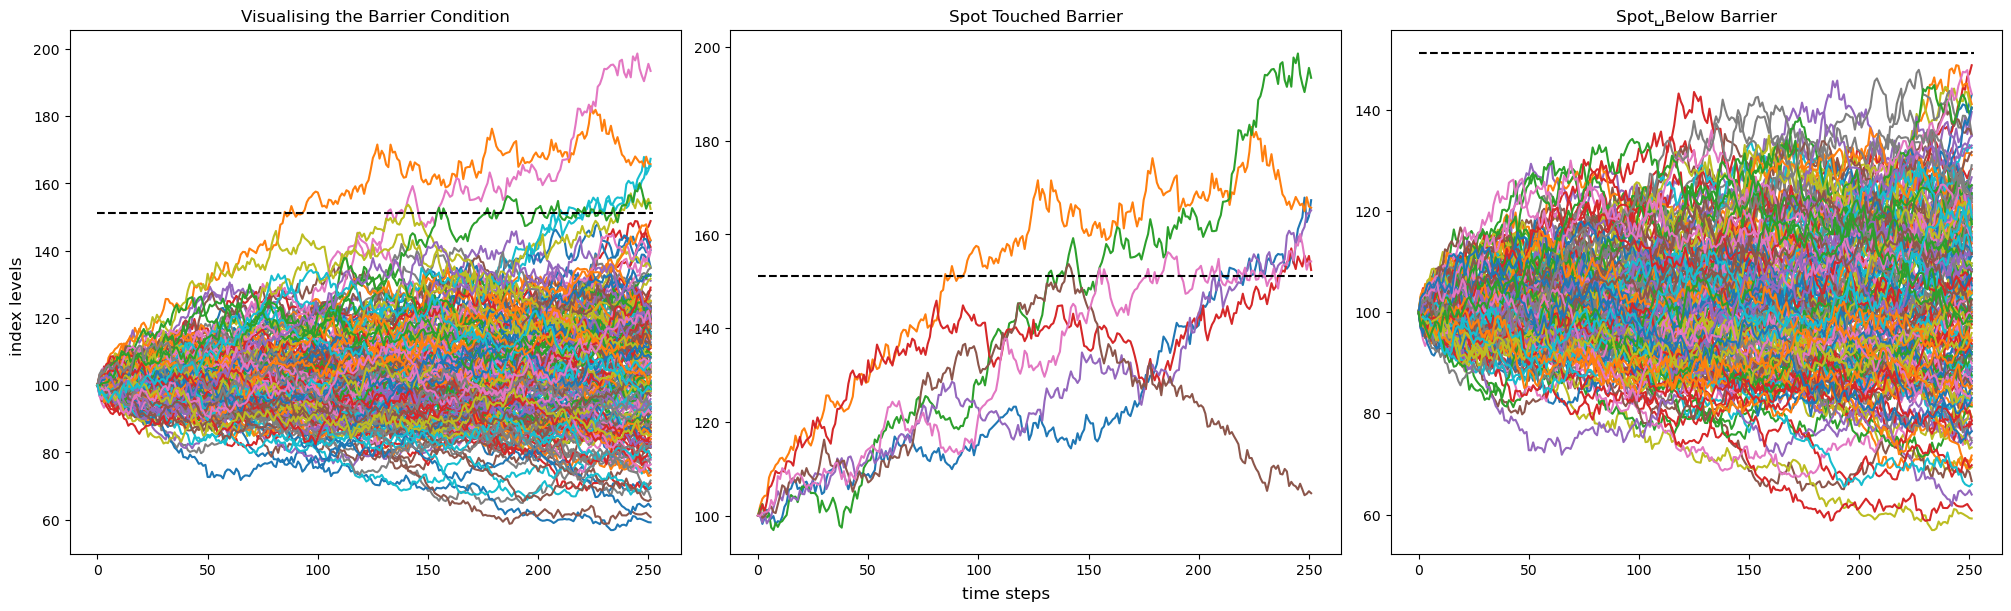

In [15]:
figure, axes = plt.subplots(1,3, figsize=(20,6), constrained_layout=True)
title = ['Visualising the Barrier Condition', 'Spot Touched Barrier', 'Spot␣Below Barrier']

# Get simulated path
S = mc.simulatepath
B_shift = mc.upandoutcall()[1]
axes[0].plot(S[:,:200])

for i in range(200):
    axes[1].plot(S[:,i]) if S[:,i].max() > B_shift else axes[2].plot(S[:,i])
    
for i in range(3):
    axes[i].set_title(title[i])
    axes[i].hlines(B_shift, 0, 252, colors='k', linestyles='dashed')
figure.supxlabel('time steps')
figure.supylabel('index levels')
plt.show()

##  <strong> 4 References

* Paul Glasserman (2004), Monte Carlo Methods in Financial Engineering
* Paul Wilmott (2007), Paul Wilmott introduces Quantitative Finance
* [Python Resources](https://github.com/kannansingaravelu/PythonResources)
* [Understanding Options](https://www.cmegroup.com/education/articles-and-reports/implied-volatility.html)

Python Labs by [Kannan Singaravelu.](https://www.linkedin.com/in/kannansi/)